## 1.2 Load Dependencies

In [40]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

## 2.2 Build Dataloading Function

In [42]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [44]:
folder = "Home_data"

POS = os.path.join(folder, 'Z45')
NEG = os.path.join(folder, 'Z10')

## 3.2 Create Tensorflow Datasets

In [45]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [46]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

## 4.1 Calculate Wave Cycle Length

In [47]:
lengths = []
path = POS
for file in os.listdir(path):
    tensor_wave = load_wav_16k_mono(os.path.join(path, file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [48]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=3680>

In [49]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=3680>

In [50]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=3680>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [51]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [192]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [193]:
spectrogram, label = preprocess(filepath, label)

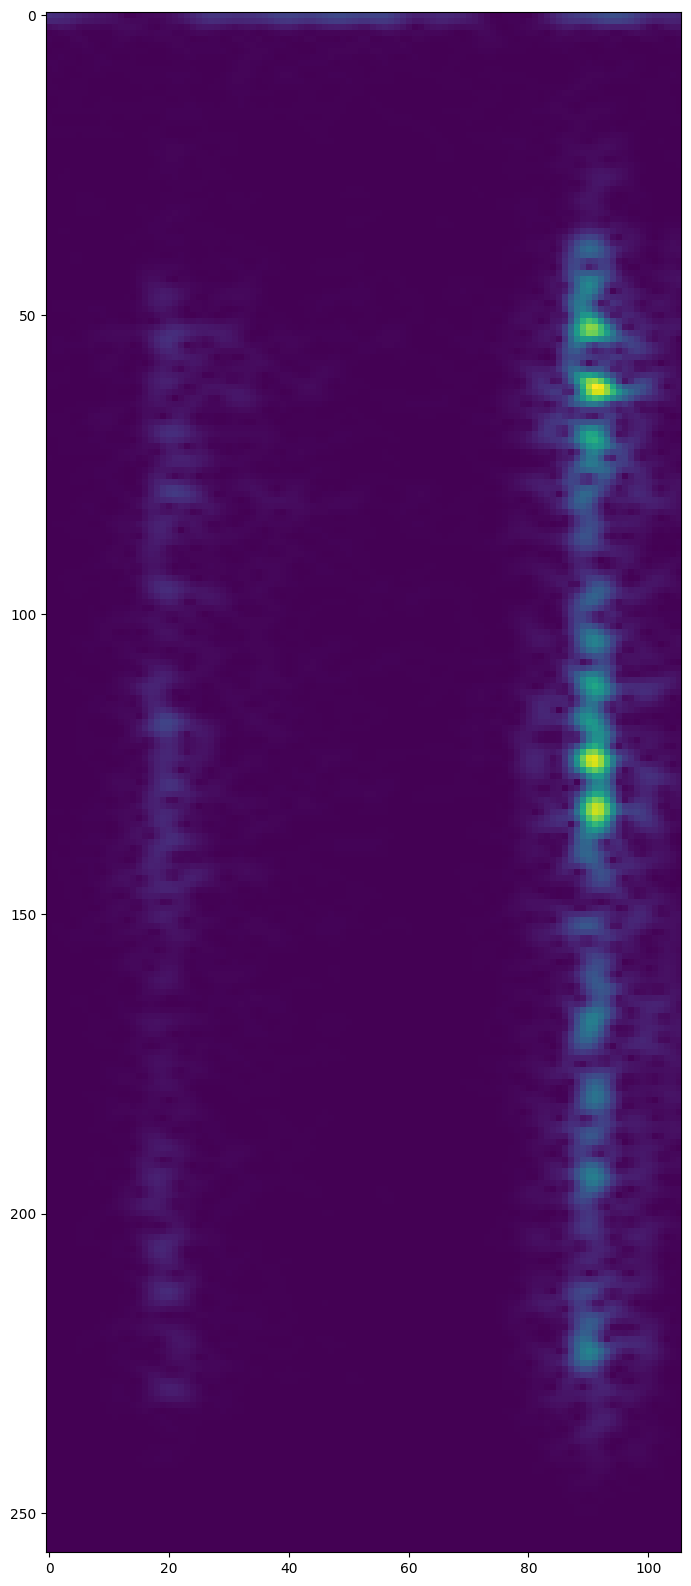

In [194]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [180]:
batch_size = 5
data = positives.concatenate(negatives)
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(batch_size)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions

In [181]:
len(data)

14

In [182]:
n = len(data)//3
train = data.take(len(data)-n)
test = data.skip(len(data)-n).take(n)
print(n)

4


## 6.3 Test One Batch

In [183]:
samples, labels = train.as_numpy_iterator().next()

In [184]:
samples.shape[1:]

(106, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [185]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [186]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=samples.shape[1:]))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [187]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [188]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 104, 255, 16)      160       
                                                                 
 conv2d_7 (Conv2D)           (None, 102, 253, 16)      2320      
                                                                 
 flatten_3 (Flatten)         (None, 412896)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               52850816  
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 52,853,425
Trainable params: 52,853,425
Non-trainable params: 0
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [189]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
10/10 [==============================] - 5s 430ms/step - loss: 0.5508 - recall_2: 0.7037 - precision_2: 0.7600 - val_loss: 0.1146 - val_recall_2: 1.0000 - val_precision_2: 0.8889
Epoch 2/4
10/10 [==============================] - 4s 423ms/step - loss: 0.0803 - recall_2: 1.0000 - precision_2: 0.9231 - val_loss: 0.0053 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 3/4
10/10 [==============================] - 4s 424ms/step - loss: 0.0036 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 3.0487e-04 - val_recall_2: 1.0000 - val_precision_2: 1.0000
Epoch 4/4
10/10 [==============================] - 4s 440ms/step - loss: 2.4755e-04 - recall_2: 1.0000 - precision_2: 1.0000 - val_loss: 1.9095e-04 - val_recall_2: 1.0000 - val_precision_2: 1.0000


In [173]:
hist.history

{'loss': [0.3746459186077118,
  0.00892555434256792,
  0.00044870152487419546,
  7.547602581325918e-05],
 'recall_1': [0.7307692170143127, 1.0, 1.0, 1.0],
 'precision_1': [0.7916666865348816, 1.0, 1.0, 1.0],
 'val_loss': [0.040151484310626984,
  0.0006021310109645128,
  0.00018014488159678876,
  7.236563396872953e-05],
 'val_recall_1': [1.0, 1.0, 1.0, 1.0],
 'val_precision_1': [1.0, 1.0, 1.0, 1.0]}

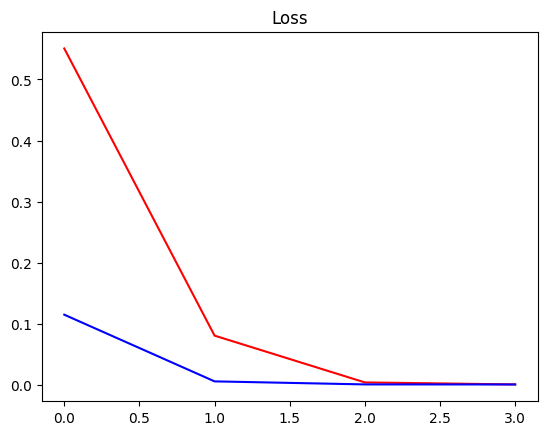

In [190]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

KeyError: 'precision_1'

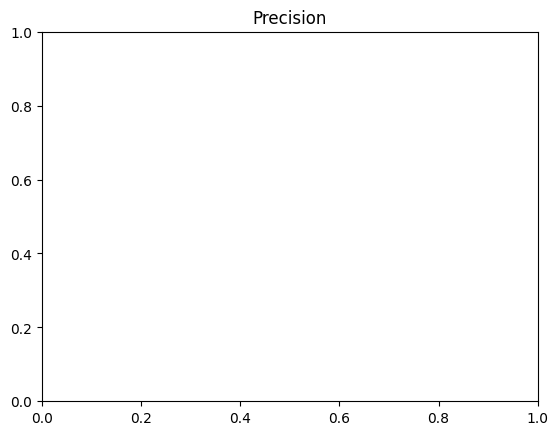

In [191]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

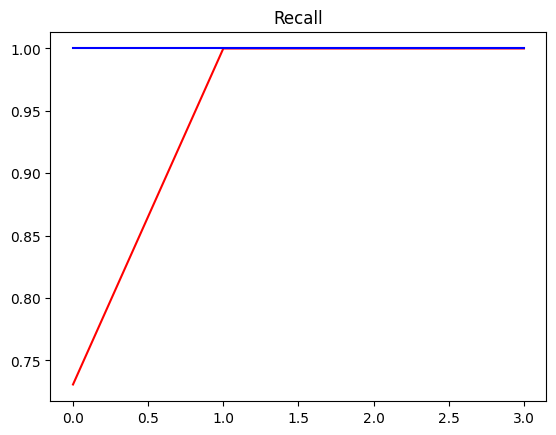

In [174]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [195]:
X_test, y_test = test.as_numpy_iterator().next()

In [177]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 83ms/step


## 8.2 Convert Logits to Classes 

In [178]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

## 9.4 Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

## 10.2 Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])